In [1]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
import pickle

%matplotlib notebook



# Data
Here we have the initial pull of datasets include:
* game_df: this is game information for all games from 2008 to 2021 including unplayed games
* test_game_codes are going to be the game_codes of games in 2021 that are played (note: game_state_id 11 is finished game, 1 is Pre-Game)
* sim_game_codes are all games (played and unplayed) of 2021
* we split up all the game_codes into "played_game_codes" and "unplayed_game_codes"

#

In [2]:
game_df = pd.read_parquet(os.path.join(data_dir, 'game_data.parquet'))
game_df = game_df.sort_values(by='game_date', ascending=False).reset_index(drop=True)
game_codes = game_df.game_code.values
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
played_game_codes = game_df.loc[game_df.game_state_id == 11, 'game_code'].values
unplayed_game_codes = game_df.loc[game_df.game_state_id != 11, 'game_code'].values
assert game_df.loc[~game_df.game_code.isin(unplayed_game_codes)].isna().sum().sum() == 0, 'Unexpected NaN values found in game data frame'
display(HTML(game_df.head(3).to_html(index=False)))
print('Games in sample: {0:d}'.format(game_codes.size))


game_code,game_date,home_team_id,away_team_id,season,home_team_abbrev,away_team_abbrev,week,home_score,away_score,status,game_state_id
2337728,2022-02-13 15:30:00,327,343,2021,Cin,LAR,23,20,23,Final,11
2337725,2022-01-30 15:30:00,343,359,2021,LAR,SF,21,20,17,Final,11
2337724,2022-01-30 14:00:00,339,327,2021,KC,Cin,21,24,27,Final,11


Games in sample: 3758


# Prior Data
Prior data is pulled from csv file and this will give us the inputs we need for the pre-game match predictions

In [3]:
prior_df = pd.read_csv(os.path.join(data_dir, 'game_priors.csv'))
display(HTML(prior_df.head(3).to_html(index=False)))

game_code,home_team_id,away_team_id,home_team_abbrev,away_team_abbrev,prior_home,prior_away,game_date
887191,329,347,Cle,Min,0.300686,0.696930,2009-09-13 13:00:00
887208,334,347,Det,Min,0.203864,0.795172,2009-09-20 13:00:00
887257,347,327,Min,Cin,0.677353,0.320797,2009-12-13 12:00:00


# Event Data
* Named event_df
* Is the play by play data from all games 2008 to 2021

# Input Features
Now that we have the datasets loaded we can load the features:
* prior_home: estimated probability of the home team winning at t=0
* prior_away: estimated probability of the away team winning at t=0
* home_team_has_ball: binary value for whether home team is in possession of the ball
* home_start_score: the score of the home team at the beginning of each play
* away_start_score: the score of the away team at the beginning of each play
* quarter: the current quarter/period the game is in (1-4 for all games, 5 if they are in the overtime period)
* play_start_time: numeric value of the time remaining in the quarter (900 at the beginning of the quarter, 0 at the end)
* yd_from_goal: the amount of yards between the line of scrimmage and the goal line for the team in possession of the ball
* down: the amount of downs that the team in possession of the ball has accumulate (1-4, down=-1 in plays that are not from scrimmage)
* ytg: the amount of yards between the current line of scrimmage and the first down line. (ytg=-1 in plays that are not from scrimmage)

# Target
remaining_exact_score: this is a numeric value for all the different combinations of remaining score (note: in this value sample, max_away_score=59 and max_home_score=62)
* for example if the current score is 17-24 (away_start_score=17 & home_start_score=24) and the final score is 27-30, then:
    *        remaining_exact_score = (27 - 17) + (62 + 1) * (30 - 24) = 422
* this ensures that all combinations of remaining exact scores are unique values


# Merged Table
full_df: the merged table of events_df and prior_df keeping only the input features and the target

In [4]:
events_df = pd.read_parquet(os.path.join(data_dir, 'event_data.parquet'))
events_df["half"] = round((events_df["quarter"] + 0.01) / 2)
events_df["home_timeout"] = np.where(((events_df["event_id"]==57)&(events_df["home_team_has_ball"]==1))|((events_df["event_id"]==58)&(events_df["home_team_has_ball"]==0)), 1, 0)
events_df["away_timeout"] = np.where(((events_df["event_id"]==57)&(events_df["home_team_has_ball"]==0))|((events_df["event_id"]==58)&(events_df["home_team_has_ball"]==1)), 1, 0)
events_df = events_df.sort_values(["game_code", "nevent"])
events_df["home_timeouts_remaining"] = np.clip(3 - events_df.groupby(["game_code", "half"])["home_timeout"].cumsum(), 0, 3)
events_df["away_timeouts_remaining"] = np.clip(3 - events_df.groupby(["game_code", "half"])["away_timeout"].cumsum(), 0, 3)

max_away_score = np.max(game_df["away_score"])
max_home_score = np.max(game_df["home_score"])
input_names = [
    "prior_home",
    "prior_away",
    "home_team_has_ball",
    "home_start_score",
    "away_start_score",
    "quarter",
    "overtime",
    "play_start_time",
    "yd_from_goal",
    "from_scrimmage",
    "kick_off",
    "punt",
    "point_after_kick",
    "two_point_attempt",
    "field_goal_attempt",
    "down",
    "ytg",
    "home_timeouts_remaining",
    "away_timeouts_remaining",
]
output_name = 'remaining_exact_score'
events_df['remaining_exact_score'] = events_df["away_rest_of_game_score"] + \
                                     (max_away_score + 1) * events_df['home_rest_of_game_score']
full_df = events_df.merge(prior_df, on="game_code")
full_df = full_df[full_df[input_names+[output_name]].notna().all(axis=1)]


In [5]:
prior_df

,game_code,home_team_id,away_team_id,home_team_abbrev,away_team_abbrev,prior_home,prior_away,game_date
0,887191,329,347,Cle,Min,0.300686,0.696930,2009-09-13 13:00:00
1,887208,334,347,Det,Min,0.203864,0.795172,2009-09-20 13:00:00
2,887257,347,327,Min,Cin,0.677353,0.320797,2009-12-13 12:00:00
3,887265,347,361,Min,Sea,0.770371,0.226579,2009-11-22 12:00:00
4,887274,347,335,Min,GB,0.600947,0.395522,2009-10-05 19:30:00
...,...,...,...,...,...,...,...,...
3486,2337689,345,348,Mia,NE,0.433925,0.562187,2022-01-09 16:25:00
3487,2337519,365,325,Jax,Hou,0.616782,0.378873,2021-12-19 13:00:00
3488,2337699,359,325,SF,Hou,0.823984,0.172885,2022-01-02 13:05:00
3489,2337632,352,365,NYJ,Jax,0.499325,0.498263,2021-12-26 13:00:00


In [6]:
# Show how the data frame looks like at the beginning and end of a game
sample_game_code = full_df.sample(1).iloc[0]['game_code']
sample_game_info = prior_df.loc[prior_df.game_code == sample_game_code, ['home_team_abbrev', 'away_team_abbrev', 'game_date']].iloc[0].tolist()
print('\nData sample for game: {0} v {1} ({2})'.format(*sample_game_info))
display(HTML(full_df.loc[full_df.game_code == sample_game_code][["game_code", "nevent"] + input_names]
             .iloc[list(range(0, 5)) + list(range(-5, 0))]
             .to_html(index=False)))


Data sample for game: Jax v NYJ (2018-09-30 13:00:00)


game_code,nevent,prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
2040913,1,0.75505,0.239722,1,0,0,1,0,900.0,65,0,1,0,0,0,0,0,-1,3,3
2040913,2,0.75505,0.239722,0,0,0,1,0,900.0,100,0,1,0,0,0,0,0,-1,3,3
2040913,3,0.75505,0.239722,0,0,0,1,0,900.0,75,1,0,0,0,0,0,1,10,3,3
2040913,4,0.75505,0.239722,0,0,0,1,0,900.0,75,0,0,0,0,0,0,0,-1,3,3
2040913,5,0.75505,0.239722,0,0,0,1,0,871.0,80,1,0,0,0,0,0,1,15,3,3
2040913,225,0.75505,0.239722,1,31,12,4,0,25.0,2,1,0,0,0,1,0,0,-1,1,0
2040913,226,0.75505,0.239722,1,31,12,4,0,25.0,65,0,1,0,0,0,0,0,-1,1,0
2040913,227,0.75505,0.239722,0,31,12,4,0,25.0,100,0,1,0,0,0,0,0,-1,1,0
2040913,228,0.75505,0.239722,0,31,12,4,0,25.0,75,1,0,0,0,0,0,1,10,1,0
2040913,229,0.75505,0.239722,0,31,12,4,0,0.0,69,0,0,0,0,0,0,2,-1,1,0


In [7]:
events_df.groupby(["event_id", "event_name", "from_scrimmage"], as_index=False).count()[["event_id", "event_name", "game_date", "from_scrimmage"]].to_clipboard()
events_df["quarter"].drop_duplicates()

152888    1
152634    2
152613    3
152533    4
402415    5
397465    6
Name: quarter, dtype: int64

# Train/Test Data Split
Training and test dataframes are created (2009-2020 are training seasons and 2021 is the test season)
# Model
This is the stored model that predicts the probability of each remaining score combination at each point of the game

In [8]:
max_home_score

62

In [9]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)

X_train = full_df.loc[~mask_test, input_names]
y_train = full_df.loc[~mask_test, output_name]
X_test = full_df.loc[mask_test, input_names].values
y_test = full_df.loc[mask_test, output_name].values
n_categories = (max_home_score + 1) * (max_away_score + 1)




# clf = MLPClassifier(
#     hidden_layer_sizes=[10,5],
#     activation='relu',
#     solver='adam',
#     alpha=0.0001,  # L2 regularization parameter
#     learning_rate_init=0.001,
#     batch_size=128,
#     random_state=1,
#     max_iter=50, #50
#     early_stopping=True,
#     validation_fraction=0.1,
#     n_iter_no_change=5,
#     verbose=True).fit(X_train, y_train)
# pickle.dump(clf, open(os.path.join(root_dir, 'models/game_score_new_4.sav'), 'wb'))

# os.system('say "done"')


In [10]:
clf = pickle.load(open(os.path.join(root_dir, "models/game_score_new_4.sav"), 'rb'))
clf_old = pickle.load(open(os.path.join(root_dir, "models/game_score.sav"), 'rb'))


In [11]:
import time
def get_model_outputs(model, input_data, running_scores):
    start_time = time.time()
    raw_output = model.predict_proba(input_data)
    # Exact score outputs    
    score_probs = np.zeros((input_data.shape[0], n_categories))
    score_probs[:, model.classes_] = raw_output
    # 1X2 prediction & team score outputs
    outcome_probs = np.zeros((input_data.shape[0], 3))
    home_score_probs = np.zeros((input_data.shape[0], max_home_score + 1))
    away_score_probs = np.zeros((input_data.shape[0], max_away_score + 1))
    for home_score in range(max_home_score + 1):
        ft_home_score = home_score + running_scores[:, 0]
        for away_score in range(max_away_score + 1):            
            # print(home_score, "-", away_score)
            ft_away_score = away_score + running_scores[:, 1]
            remaining_prob = score_probs[:, away_score + (max_away_score + 1) * home_score]
            # 1X2 - Home win
            outcome_probs[:, 0] = np.where(ft_home_score > ft_away_score,
                                           outcome_probs[:, 0] + remaining_prob,
                                           outcome_probs[:, 0])
            # 1X2 - Draw
            outcome_probs[:, 1] = np.where(ft_home_score == ft_away_score,
                                           outcome_probs[:, 1] + remaining_prob,
                                           outcome_probs[:, 1])
            # 1X2 - Away win
            outcome_probs[:, 2] = np.where(ft_home_score < ft_away_score,
                                           outcome_probs[:, 2] + remaining_prob,
                                           outcome_probs[:, 2])
            # Team scores
            home_score_probs[:, home_score] += remaining_prob
            away_score_probs[:, away_score] += remaining_prob
    return {
        'remaining_score': score_probs,
        'home_score': home_score_probs,
        'away_score': away_score_probs,
        'ft_outcome': outcome_probs
    }

## Usage example
Below is just a little bit of code that shows how the input and output data looks like for a few samples in a random game:

In [12]:
example_game_code = np.random.choice(test_game_codes)
example_indices = [0, 1, -2, -1]
example_input = full_df.sort_values("nevent").loc[full_df.game_code == example_game_code, input_names].values[example_indices]
full_df = full_df.sort_values(["game_code", "nevent"], ascending=True)
example_running_score = full_df.loc[full_df.game_code == example_game_code,
                                    ['home_start_score', 'away_start_score']].values[example_indices]
example_output = get_model_outputs(clf, example_input, example_running_score)
print('\nExample input data:')
display(HTML(pd.DataFrame(data=example_input, columns=input_names).to_html(index=False)))

# print('\nExample outputs (exact score):')
# print(example_output['remaining_score'][0][0:10])
# print(example_output['remaining_score'][0][10:20])
# print(example_output['remaining_score'][0][20:30])

print('\nExample outputs (home team score):')
display(HTML(pd.DataFrame(data=example_output['home_score'], columns=np.arange(max_home_score + 1)).to_html(index=False)))

print('\nExample outputs (away team score):')
display(HTML(pd.DataFrame(data=example_output['away_score'], columns=np.arange(max_away_score + 1)).to_html(index=False)))

print('\nExample outputs (1X2):')
display(HTML(pd.DataFrame(data=example_output['ft_outcome'], columns=['home win', 'draw', 'away win']).to_html(index=False)))


Example input data:


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
0.433925,0.562187,0.0,0.0,0.0,1.0,0.0,900.0,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,3.0
0.433925,0.562187,1.0,0.0,0.0,1.0,0.0,900.0,97.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,3.0
0.433925,0.562187,1.0,27.0,24.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
0.433925,0.562187,1.0,33.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0



Example outputs (home team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0.009838,0.000009,0.000293,0.016179,0.000028,0.000706,0.018403,0.021251,0.002653,0.012664,0.040314,0.004919,0.011559,0.041871,0.030007,0.011761,0.038669,0.065762,0.010653,0.024168,0.068011,0.037392,0.016378,0.045692,0.066089,0.011262,2.897157e-02,0.052552,0.029250,1.277095e-02,0.032425,0.045873,8.517669e-03,1.598872e-02,2.762939e-02,1.904901e-02,8.325045e-03,1.436408e-02,2.573535e-02,3.794225e-03,6.906308e-03,9.016625e-03,8.772141e-03,4.897699e-03,4.398241e-03,1.120467e-02,1.914258e-03,2.524748e-03,4.907434e-03,4.989153e-03,2.983943e-04,1.863820e-03,1.939816e-03,5.715457e-04,5.563334e-04,1.673711e-03,5.609045e-04,1.144707e-04,2.825548e-04,5.854230e-04,2.182142e-10,0.0,2.441448e-04
0.009718,0.000008,0.000285,0.016058,0.000025,0.000686,0.018298,0.021047,0.002575,0.012536,0.040262,0.004807,0.011488,0.041951,0.029842,0.011598,0.038754,0.066069,0.010482,0.024155,0.068649,0.037345,0.016247,0.046050,0.066678,0.011094,2.907666e-02,0.053066,0.029128,1.268133e-02,0.032565,0.046223,8.411479e-03,1.589358e-02,2.768741e-02,1.895498e-02,8.256118e-03,1.425645e-02,2.576481e-02,3.723067e-03,6.840611e-03,8.937694e-03,8.715080e-03,4.842564e-03,4.338130e-03,1.118473e-02,1.882094e-03,2.507746e-03,4.856630e-03,4.952462e-03,2.917602e-04,1.830695e-03,1.904435e-03,5.633500e-04,5.467798e-04,1.652908e-03,5.507645e-04,1.117867e-04,2.788494e-04,5.772439e-04,2.166595e-10,0.0,2.399501e-04
0.755952,0.006755,0.009394,0.089355,0.001658,0.001448,0.021704,0.083042,0.007384,0.002635,0.008689,0.001072,0.000257,0.001929,0.006272,0.000560,0.000195,0.000771,0.000080,0.000027,0.000113,0.000536,0.000068,0.000018,0.000042,0.000007,1.021759e-06,0.000004,0.000023,1.062374e-06,0.000002,0.000002,5.402510e-07,8.750075e-09,9.101978e-08,8.972196e-07,1.077111e-08,9.845226e-07,1.015148e-07,1.727263e-09,8.645911e-11,1.778418e-09,3.245647e-08,1.393400e-11,9.870819e-15,5.132467e-11,2.286218e-09,1.503658e-14,1.544151e-09,1.385330e-09,5.015018e-13,5.122628e-11,4.747944e-11,5.267033e-14,2.224484e-22,1.466718e-23,1.222071e-14,1.293123e-08,3.914372e-26,5.224182e-11,4.736895e-11,0.0,6.709027e-09
0.810422,0.006180,0.008117,0.066538,0.000765,0.001382,0.013381,0.073228,0.003853,0.001691,0.005946,0.000414,0.000149,0.001208,0.005079,0.000333,0.000112,0.000542,0.000039,0.000014,0.000073,0.000421,0.000046,0.000011,0.000027,0.000005,5.712564e-07,0.000003,0.000017,5.379190e-07,0.000002,0.000001,2.204796e-07,4.117827e-09,6.882512e-08,4.730122e-07,3.442260e-09,4.470942e-07,5.132074e-08,8.263183e-10,5.724597e-11,1.550362e-09,1.013962e-08,3.194084e-12,5.874885e-15,3.547034e-11,8.128525e-10,1.211826e-14,9.716026e-11,3.813081e-10,3.746035e-13,3.504919e-11,3.369166e-11,4.008654e-14,7.334548e-24,5.378525e-24,9.316953e-15,1.197603e-08,1.778547e-28,3.706356e-11,3.360939e-11,0.0,5.555068e-09



Example outputs (away team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0.016265,0.000034,0.001044,0.021644,9.697629e-05,0.001397,0.021711,0.034283,0.003169,0.019875,0.060436,0.003855,0.014152,0.051302,0.040996,0.009912,0.038094,0.083324,0.011476,0.019790,0.065772,0.036030,0.012606,0.050125,0.060099,0.012014,2.472206e-02,0.048661,0.025625,0.008738,0.025495,3.467463e-02,0.007492,1.523517e-02,2.521871e-02,0.014320,6.746283e-03,1.387278e-02,1.547428e-02,3.434160e-03,4.157426e-03,1.298917e-02,6.566148e-03,2.227636e-03,2.700352e-03,4.680808e-03,6.756322e-04,6.256240e-04,1.983671e-03,1.878934e-03,1.267668e-04,1.209402e-03,4.065527e-04,1.274590e-06,1.907210e-07,1.277801e-04,2.725607e-05,0.0,0.0,4.039720e-04
0.016141,0.000031,0.001029,0.021578,9.087734e-05,0.001369,0.021664,0.034211,0.003089,0.019813,0.060789,0.003752,0.014065,0.051563,0.040934,0.009794,0.038126,0.083972,0.011310,0.019696,0.066293,0.035986,0.012463,0.050513,0.060560,0.011858,2.468995e-02,0.048920,0.025551,0.008594,0.025477,3.474417e-02,0.007376,1.512478e-02,2.516656e-02,0.014217,6.654775e-03,1.376418e-02,1.536072e-02,3.390051e-03,4.104549e-03,1.289849e-02,6.488913e-03,2.185418e-03,2.654281e-03,4.613731e-03,6.647274e-04,6.124272e-04,1.945165e-03,1.851979e-03,1.236189e-04,1.187107e-03,4.004698e-04,1.158433e-06,1.722639e-07,1.247902e-04,2.613853e-05,0.0,0.0,3.970288e-04
0.761336,0.004251,0.004557,0.059747,2.462176e-06,0.000794,0.021802,0.095021,0.022410,0.002900,0.008419,0.002467,0.000655,0.002365,0.008537,0.002593,0.000181,0.000561,0.000256,0.000102,0.000126,0.000675,0.000087,0.000007,0.000031,0.000078,8.854538e-07,0.000003,0.000018,0.000002,0.000002,1.359672e-06,0.000004,1.365272e-07,1.217686e-07,0.000007,6.491915e-09,5.244154e-08,1.127227e-06,9.896235e-13,1.602525e-10,3.120365e-10,3.170090e-10,2.604443e-08,7.805080e-11,3.123813e-07,9.302127e-11,6.550246e-14,6.100805e-13,7.760317e-14,9.821741e-15,2.505909e-14,1.039975e-17,4.068934e-14,1.108490e-09,1.772859e-08,3.471320e-19,0.0,0.0,1.208709e-18
0.807786,0.003079,0.004521,0.035618,2.710209e-07,0.000523,0.014707,0.092671,0.018665,0.001901,0.005509,0.001411,0.000521,0.001703,0.007198,0.002558,0.000143,0.000391,0.000182,0.000072,0.000089,0.000543,0.000081,0.000006,0.000025,0.000069,5.970110e-07,0.000002,0.000012,0.000002,0.000001,8.180629e-07,0.000003,5.808032e-08,7.158893e-08,0.000007,3.356816e-09,2.092367e-08,4.682321e-07,6.779954e-13,7.522106e-11,5.823302e-11,3.170636e-10,5.767941e-08,6.274304e-11,1.842371e-07,6.600170e-11,5.169919e-14,4.694869e-13,5.905836e-14,4.673612e-15,2.001536e-14,2.027718e-18,2.600729e-14,7.003311e-10,7.962622e-09,2.385947e-20,0.0,0.0,1.336969e-19



Example outputs (1X2):


home win,draw,away win
0.557893,0.025184,0.416923
0.558858,0.025135,0.416008
0.829942,0.045373,0.124684
0.985535,0.001393,0.013071


### Visualization of predictions
This is a simple interactive dashboard that lets the user select any game from the test data set and plots match outcome (1X2) and team score predictions. Just pick a game from the drop-down menu and click the "Plot" button.

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/853232475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/853232475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.it

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/853232475.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/853232475.py:82: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


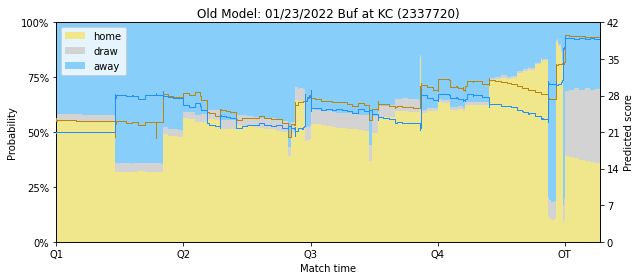

In [141]:
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names_old].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf_old, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title("Old Model: " + '{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, 49, 7))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/671270838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/671270838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.it

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/671270838.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/671270838.py:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


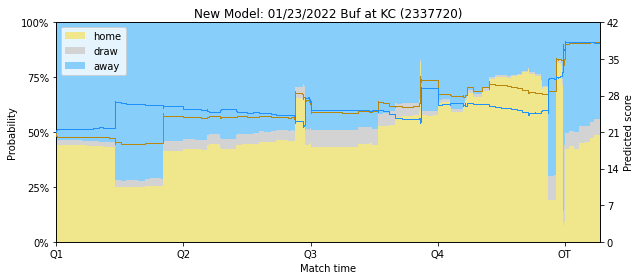

In [138]:
input_names_old = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'down', 'ytg']
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(rf, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title("New Model: "'{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, 49, 7))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

Home Score Projections: 
[20 20 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 16 16 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 14 14 24 24 24 24 24 24 24 24
 20 20 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 21 21
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23
 30 30 23 23 23 23 23 23 23 23 23 23 26 26 26 26 26 26 26 26 26 26 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 30 30
 26 26 30 30 30 30 26 26 2

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:131: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


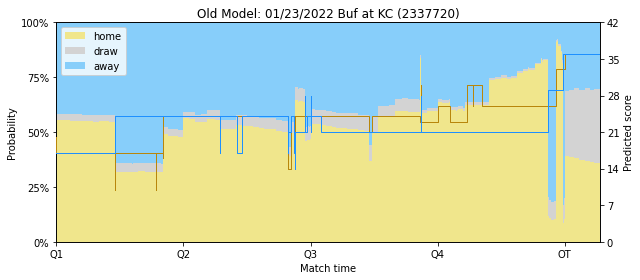

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Home Score Projections: 
[20 20 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 16 16 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 14 14 24 24 24 24 24 24 24 24
 20 20 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 21 21
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23
 30 30 23 23 23 23 23 23 23 23 23 23 26 26 26 26 26 26 26 26 26 26 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 30 30
 26 26 30 30 30 30 26 26 2

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:131: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Home Score Projections: 
[20 20 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 16 16 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 14 14 24 24 24 24 24 24 24 24
 20 20 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 21 21
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23
 30 30 23 23 23 23 23 23 23 23 23 23 26 26 26 26 26 26 26 26 26 26 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 30 30
 26 26 30 30 30 30 26 26 2

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:131: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Home Score Projections: 
[20 20 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 10 10 17 17 17 17 16 16 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 14 14 24 24 24 24 24 24 24 24
 20 20 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 21 21
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 21 21 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23
 30 30 23 23 23 23 23 23 23 23 23 23 26 26 26 26 26 26 26 26 26 26 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 30 30
 26 26 30 30 30 30 26 26 2

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:131: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1448163651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [108]:
# old model

%matplotlib inline
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string


def get_score_predictions(n, plays, home_score, away_score):
    home_scores = []
    away_scores = []

    for z in range(plays):
        scores = [(x, y) for x in range(max_home_score) for y in range(max_away_score)]
        scores

        for i in range(max_home_score):
            for j in range(max_away_score):
                index = scores.index((i,j))
                scores[index] += (home_score[z][i] * away_score[z][j],)

        probs = np.array([x[n] for x in scores])

        top_values = np.argsort(-probs)[0:10]
        score1 = scores[top_values[0]]
        score2 = scores[top_values[1]]

        home_scores.append((score1[0], score2[0]))
        away_scores.append((score1[1], score2[1]))
        
    return home_scores, away_scores
                

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names_old].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf_old, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title("Old Model: "'{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home - plot most common and second most common score
    home_scores, away_scores = get_score_predictions(2, len(plot_running_score), plot_output['home_score'], plot_output['away_score'])
    plot_home_score = plot_running_score[:, 0] + [n[0] for n in home_scores]
#     home_output = plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1))
#     plot_home_score = plot_running_score[:, 0] + \
#         np.argsort(-home_output, axis=1)[:,0]
#         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    #Second most common home score, as a dashed line
#     plot_home_score_dash = plot_running_score[:,0] + [n[1] for n in home_scores]
# #     plot_home_score_dash = plot_running_score[:, 0] + \
# #         np.argsort(-home_output, axis=1)[:,1]
# #         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#     plot_home_score_dash = np.vstack((plot_home_score_dash, plot_home_score_dash)).flatten(order='F')[:-1]
#     h_ax_twin.plot(plot_x, plot_home_score_dash, '-k', linewidth=1, zorder=10, color='darkgoldenrod', 
#                    label='home score', linestyle = 'dashed')
    
    
#     # Away
    plot_away_score = plot_running_score[:, 1] + [n[0] for n in away_scores]
#     away_output = plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1))
#     plot_away_score = plot_running_score[:, 1] + \
#         np.argsort(-away_output, axis = 1)[:,0]
#         #np.argmax(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
#     #Second most common away score, as a dashed line
#     plot_away_score_dash = plot_running_score[:, 1] + [n[1] for n in away_scores]
# #     plot_away_score_dash = plot_running_score[:, 1] + \
# #         np.argsort(-away_output, axis=1)[:,1]
# #         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
# #         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#     plot_away_score_dash = np.vstack((plot_away_score_dash, plot_away_score_dash)).flatten(order='F')[:-1]
#     h_ax_twin.plot(plot_x, plot_away_score_dash, '-k', linewidth=1, zorder=10, color='dodgerblue', 
#                    label='home score', linestyle = 'dashed')
    
    print('Home Score Projections: ')
    print(plot_home_score)
#     print(plot_home_score_dash)
    
    print('Away Score Projections: ')
    print(plot_away_score)
#     print(plot_away_score_dash)
    #values = np.ceil(np.append(plot_home_score, plot_away_score))
    #ctr = Counter(values.ravel())
    #mode_score = int(ctr.most_common(2)[0][0])
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, 49, 7))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)


ValueError: x, y, and format string must not be None

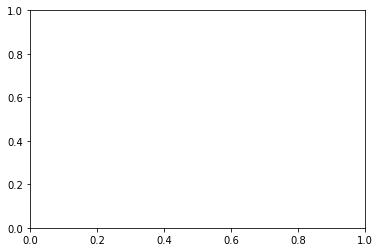

In [100]:
plt.plot(h_f)

In [61]:
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]


0      2022-02-13 15:30:00 LAR at Cin (2337728)
1       2022-01-30 15:30:00 SF at LAR (2337725)
2       2022-01-30 14:00:00 Cin at KC (2337724)
3       2022-01-23 17:30:00 Buf at KC (2337720)
4       2022-01-23 15:00:00 LAR at TB (2337721)
                         ...                   
280    2021-09-12 13:00:00 Pit at Buf (2337431)
281    2021-09-12 13:00:00 Phi at Atl (2337430)
282    2021-09-12 12:00:00 Ari at Ten (2337434)
283    2021-09-12 12:00:00 Jax at Hou (2337438)
284     2021-09-09 20:20:00 Dal at TB (2337429)
Name: game_description, Length: 285, dtype: object

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1563335283.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1563335283.py:128: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


Home Score Projections: 
Away Score Projections: 


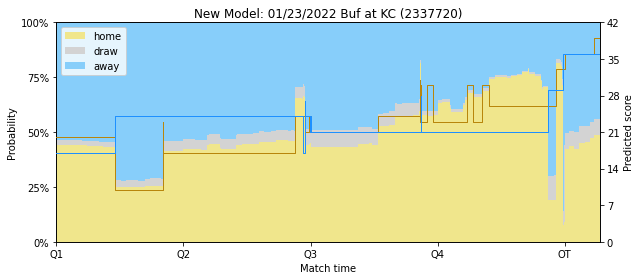

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1563335283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_2763/1563335283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.

In [127]:
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df["game_date_formated"] = [x.strftime("%m/%d/%Y") for x in game_df["game_date"]]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date_formated, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string


def get_score_predictions(n, plays, home_score, away_score):
    home_scores = []
    away_scores = []

    for z in range(plays):
        scores = [(x, y) for x in range(max_home_score) for y in range(max_away_score)]
        scores

        for i in range(max_home_score):
            for j in range(max_away_score):
                index = scores.index((i,j))
                scores[index] += (home_score[z][i] * away_score[z][j],)

        probs = np.array([x[n] for x in scores])

        top_values = np.argsort(-probs)[0:10]
        score1 = scores[top_values[0]]
        score2 = scores[top_values[1]]

        home_scores.append((score1[0], score2[0]))
        away_scores.append((score1[1], score2[1]))
        
    return home_scores, away_scores
                

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(rf, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title("New Model: " + '{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home - plot most common and second most common score
    home_scores, away_scores = get_score_predictions(2, len(plot_running_score), plot_output['home_score'], plot_output['away_score'])
    plot_home_score = plot_running_score[:, 0] + [n[0] for n in home_scores]
#     home_output = plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1))
#     plot_home_score = plot_running_score[:, 0] + \
#         np.argsort(-home_output, axis=1)[:,0]
#         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    #Second most common home score, as a dashed line
#     plot_home_score_dash = plot_running_score[:,0] + [n[1] for n in home_scores]
# #     plot_home_score_dash = plot_running_score[:, 0] + \
# #         np.argsort(-home_output, axis=1)[:,1]
# #         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#     plot_home_score_dash = np.vstack((plot_home_score_dash, plot_home_score_dash)).flatten(order='F')[:-1]
#     h_ax_twin.plot(plot_x, plot_home_score_dash, '-k', linewidth=1, zorder=10, color='darkgoldenrod', 
#                    label='home score', linestyle = 'dashed')
    
    
#     # Away
    plot_away_score = plot_running_score[:, 1] + [n[0] for n in away_scores]
#     away_output = plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1))
#     plot_away_score = plot_running_score[:, 1] + \
#         np.argsort(-away_output, axis = 1)[:,0]
#         #np.argmax(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
#         #np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
#     #Second most common away score, as a dashed line
#     plot_away_score_dash = plot_running_score[:, 1] + [n[1] for n in away_scores]
# #     plot_away_score_dash = plot_running_score[:, 1] + \
# #         np.argsort(-away_output, axis=1)[:,1]
# #         #np.argmax(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
# #         #np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
#     plot_away_score_dash = np.vstack((plot_away_score_dash, plot_away_score_dash)).flatten(order='F')[:-1]
#     h_ax_twin.plot(plot_x, plot_away_score_dash, '-k', linewidth=1, zorder=10, color='dodgerblue', 
#                    label='home score', linestyle = 'dashed')
    
    print('Home Score Projections: ')
#     print(plot_home_score)
#     print(plot_home_score_dash)
    
    print('Away Score Projections: ')
#     print(plot_away_score)
#     print(plot_away_score_dash)
    #values = np.ceil(np.append(plot_home_score, plot_away_score))
    #ctr = Counter(values.ravel())
    #mode_score = int(ctr.most_common(2)[0][0])
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, 49, 7))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

In [15]:
plot_game_code = 2337720

plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names_old].values
plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf_old, plot_input, plot_running_score)
output_df = pd.concat([full_df.loc[full_df.game_code == plot_game_code,full_df.columns], pd.DataFrame(plot_input, columns = input_names_old), pd.DataFrame(plot_output["ft_outcome"],columns=["away_win", "draw", "home_win"])], axis=1)
# output_df.to_csv("Bills at Chiefs 01-23-2022.csv")



/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


'Old Model: 01/23/2022 Buf at KC (2337720)'

In [16]:
plot_game_code = 2337720

plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf, plot_input, plot_running_score)
pd.concat([pd.DataFrame(plot_input, columns=input_names), pd.DataFrame(plot_output["ft_outcome"],columns=["away_win", "draw", "home_win"])], axis=1).to_csv("Bills at Chiefs 01-23-2022 new.csv")



/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [17]:
pd.DataFrame(plot_output["ft_outcome"],columns=["away_win", "draw", "home_win"])

,away_win,draw,home_win
0,0.559831,0.025084,0.415085
1,0.555638,0.025293,0.419070
2,0.557925,0.025182,0.416893
3,0.558121,0.025172,0.416706
4,0.558623,0.025147,0.416230
...,...,...,...
216,0.523937,0.110054,0.366009
217,0.522721,0.110048,0.367230
218,0.523603,0.110115,0.366282
219,0.523426,0.109829,0.366746


In [18]:
X_test = full_df.loc[mask_test, input_names_old].values
y_test = full_df.loc[mask_test, output_name].values
clf_old.score(X_test, y_test)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


0.08815081382680182

In [19]:
X_test = full_df.loc[mask_test, input_names].values
y_test = full_df.loc[mask_test, output_name].values
clf.score(X_test, y_test)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


0.0926243850902968

In [20]:
full_df

,game_code,game_date_x,season,home_team_id_x,away_team_id_x,home_final_score,away_final_score,home_team_outcome,nevent,quarter,...,home_timeouts_remaining,away_timeouts_remaining,remaining_exact_score,home_team_id_y,away_team_id_y,home_team_abbrev,away_team_abbrev,prior_home,prior_away,game_date_y
0,887184,2009-09-10,2009,356,336,13,10,W,1,1,...,3,3,790,356,336,Pit,Ten,0.689458,0.303227,2009-09-10 20:30:00
1,887184,2009-09-10,2009,356,336,13,10,W,2,1,...,3,3,790,356,336,Pit,Ten,0.689458,0.303227,2009-09-10 20:30:00
2,887184,2009-09-10,2009,356,336,13,10,W,3,1,...,3,3,790,356,336,Pit,Ten,0.689458,0.303227,2009-09-10 20:30:00
3,887184,2009-09-10,2009,356,336,13,10,W,4,1,...,3,3,790,356,336,Pit,Ten,0.689458,0.303227,2009-09-10 20:30:00
4,887184,2009-09-10,2009,356,336,13,10,W,5,1,...,3,3,790,356,336,Pit,Ten,0.689458,0.303227,2009-09-10 20:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760574,2411004,2021-12-21,2021,343,361,20,10,W,193,4,...,1,0,0,343,361,LAR,Sea,0.687837,0.310144,2021-12-21 16:00:00
760575,2411004,2021-12-21,2021,343,361,20,10,W,194,4,...,1,0,0,343,361,LAR,Sea,0.687837,0.310144,2021-12-21 16:00:00
760576,2411004,2021-12-21,2021,343,361,20,10,W,195,4,...,1,0,0,343,361,LAR,Sea,0.687837,0.310144,2021-12-21 16:00:00
760577,2411004,2021-12-21,2021,343,361,20,10,W,196,4,...,1,0,0,343,361,LAR,Sea,0.687837,0.310144,2021-12-21 16:00:00


In [21]:
# plot_game_code = 2337716
# plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names_old].values
# plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
# plot_output = get_model_outputs(clf_old, plot_input, plot_running_score)    


In [22]:
# plot_game_code = 2337716
# plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
# plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
# plot_output = get_model_outputs(clf, plot_input, plot_running_score)    


## Preparing predictions for 2021 season simulation
This is the final section of this notebook, and its purpose is to use the model we have trained to generate match predictions for all games in the 2021/22 season. These will be used in the next notebook to simulate the outcome of the competition.

Since the purpose of this tutorial is not to be run live while games play, we can make the following simplification: we will assume that all 2021 games are either finished or not yet started, and will use observed results and predictions for them, resepectively. Therefore, we will gather input features and generate pre-game predictions only for unplayed games.

First, let's get results for played games:

In [23]:
results_df = game_df.loc[game_df.season==2021, ["game_code", "home_team_id", "away_team_id", "home_score", "away_score"]]
results_df = results_df.set_index('game_code').loc[np.intersect1d(sim_game_codes, played_game_codes)].reset_index()
team_names = game_df.loc[game_df.season==2021, ["home_team_id", "home_team_abbrev"]]
division_data = pd.read_parquet(os.path.join(data_dir, "division_data.parquet"))
team_names =team_names.rename(columns={'home_team_id': 'id', 'home_team_abbrev': 'name'}).drop_duplicates()
current_division_data = division_data.loc[division_data.season==2021].rename(columns={'team_id': 'id'})
team_names= team_names.merge(current_division_data)
team_names = team_names.to_dict(orient='records')

Now let's deal with unplayed games: get input features and pass to the model to get predictions:

In [24]:
sim_df = game_df.set_index('game_code').loc[unplayed_game_codes, ['home_team_id', 'away_team_id']].reset_index()

# Add prior match outcome probabilities
sim_df = sim_df.merge(
    right=prior_df[['game_code'] + np.intersect1d(input_names, prior_df.columns).tolist()],
    how='left', on='game_code'
)
# input_names = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'overtime', 'play_start_time', 'yd_from_goal', 'from_scrimmage', 'kick_off', 'punt', 'point_after_kick', 'two_point_attempt', 'field_goal_attempt', 'down', 'ytg']

sim_df['prior_home'] = np.where(np.isnan(sim_df["prior_home"]), np.mean(full_df["prior_home"]), sim_df["prior_home"])
sim_df['prior_away'] = np.where(np.isnan(sim_df["prior_away"]), np.mean(full_df["prior_away"]), sim_df["prior_away"])
sim_df['home_team_has_ball'] = 0
sim_df['home_start_score'] = 0
sim_df['away_start_score'] = 0
sim_df['quarter'] = 1
sim_df['overtime'] = 0
sim_df['play_start_time'] = 900
sim_df['yd_from_goal'] = 70
sim_df['from_scrimmage'] = 0
sim_df['kick_off'] = 1
sim_df['punt'] = 0
sim_df['point_after_kick'] = 0
sim_df['two_point_attempt'] = 0
sim_df['field_goal_attempt'] = 0
sim_df['down'] = 0
sim_df['ytg'] = -1
sim_df['home_timeouts_remaining'] = 3
sim_df['away_timeouts_remaining'] = 3
sim_input = sim_df[input_names].values
sim_running_score = sim_df[['home_start_score', 'away_start_score']].values
sim_output = get_model_outputs(clf, sim_input, sim_running_score)


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.

Finally, put results and predictions together and store in a JSON file for the simulation notebook:

In [25]:

# Create predictions object
predictions = []
for ind_game, game_code in enumerate(sim_df.game_code.values):
    predictions.append({
        'game_code': int(game_code),
        'home_team_id': int(sim_df.iloc[ind_game]['home_team_id']),
        'away_team_id': int(sim_df.iloc[ind_game]['away_team_id']),
        'pred_exact_score': sim_output['remaining_score'][ind_game].tolist(),
        'pred_outcome': sim_output['ft_outcome'][ind_game].tolist(),
        'current_score': sim_running_score[ind_game].tolist()
    })
sim_data = {
    'teams': team_names,
    'results': results_df.to_dict(orient='records'),
    'predictions': predictions,
    'prediction_params': {'max_home_score': int(max_home_score), 'max_away_score': int(max_away_score)}
}
with open(os.path.join(data_dir, 'simulation_inputs.json'), 'w') as f:
    json.dump(sim_data, f)
os.system('say "done"')


0

In [26]:
play_subset = (full_df.game_code == 2337619) & (full_df.down==4)&(full_df.from_scrimmage==1)

play_idx = 134
plot_input = full_df.loc[play_subset, input_names].values
plot_running_score = full_df.loc[play_subset, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf, plot_input, plot_running_score)    
plot_input_df = pd.DataFrame(plot_input, columns=input_names)


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [27]:
plot_input_opposite = full_df.loc[play_subset, input_names].values
for x in range(len(plot_input)):
    plot_input_opposite[x, 11] = 1 - plot_input_opposite[x][11]
pd.DataFrame(plot_input, columns=input_names)

,prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
0,0.410737,0.588496,1.0,0.0,0.0,1.0,0.0,785.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,3.0,3.0
1,0.410737,0.588496,0.0,0.0,0.0,1.0,0.0,644.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,3.0
2,0.410737,0.588496,0.0,0.0,7.0,2.0,0.0,864.0,75.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,3.0,2.0
3,0.410737,0.588496,1.0,0.0,7.0,2.0,0.0,737.0,63.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,10.0,3.0,2.0
4,0.410737,0.588496,0.0,0.0,7.0,2.0,0.0,400.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,2.0
5,0.410737,0.588496,1.0,0.0,10.0,2.0,0.0,312.0,72.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,7.0,3.0,2.0
6,0.410737,0.588496,1.0,0.0,10.0,2.0,0.0,158.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,2.0
7,0.410737,0.588496,0.0,3.0,10.0,2.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,10.0,3.0,1.0
8,0.410737,0.588496,1.0,3.0,13.0,3.0,0.0,685.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,12.0,3.0,3.0
9,0.410737,0.588496,0.0,10.0,13.0,3.0,0.0,566.0,67.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,3.0,3.0


In [28]:
plot_output = get_model_outputs(clf, plot_input, plot_running_score)
plot_output_opposite = get_model_outputs(clf, plot_input_opposite, plot_running_score)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [29]:
pd.DataFrame(plot_output_opposite["ft_outcome"])

,0,1,2
0,0.560900,0.025027,0.414073
1,0.557002,0.025228,0.417770
2,0.358557,0.044948,0.596495
3,0.341305,0.049668,0.609027
4,0.319257,0.058851,0.621892
5,0.227536,0.046763,0.725701
6,0.230279,0.051228,0.718493
7,0.289862,0.061889,0.648250
8,0.187408,0.048634,0.763958
9,0.378177,0.065553,0.556270


In [30]:
pd.DataFrame(plot_output["ft_outcome"])

,0,1,2
0,0.560722,0.025036,0.414242
1,0.557180,0.025219,0.417601
2,0.359136,0.044802,0.596062
3,0.339457,0.050244,0.610299
4,0.320476,0.058508,0.621017
5,0.225412,0.046809,0.727779
6,0.231937,0.051227,0.716836
7,0.290432,0.061649,0.647918
8,0.185165,0.048665,0.766169
9,0.374893,0.065935,0.559172


In [31]:
test_df = full_df.loc[~mask_test, input_names]
scores_df = full_df.loc[~mask_test, ['home_final_score', 'away_final_score']]


In [ ]:
# plot_input = full_df.loc[~mask_test, input_names].values
# plot_running_score = full_df.loc[~mask_test, ['home_start_score', 'away_start_score']].values
# plot_output = get_model_outputs(clf, plot_input, plot_running_score)


In [32]:
prior_df[prior_df["game_code"]==2411003]

,game_code,home_team_id,away_team_id,home_team_abbrev,away_team_abbrev,prior_home,prior_away,game_date
3396,2411003,354,363,Phi,Was,0.626113,0.372436,2021-12-21 19:00:00


In [33]:
sim_df['prior_home'] = np.where(np.isnan(sim_df["prior_home"]), np.mean(full_df["prior_home"]), sim_df["prior_home"])
sim_df['prior_away'] = np.where(np.isnan(sim_df["prior_away"]), np.mean(full_df["prior_away"]), sim_df["prior_away"])
sim_df['home_team_has_ball'] = 0
sim_df['home_start_score'] = 0
sim_df['away_start_score'] = 0
sim_df['quarter'] = 1
sim_df['overtime'] = 0
sim_df['play_start_time'] = 900
sim_df['yd_from_goal'] = 70
sim_df['from_scrimmage'] = 0
sim_df['kick_off'] = 1
sim_df['punt'] = 0
sim_df['point_after_kick'] = 0
sim_df['two_point_attempt'] = 0
sim_df['field_goal_attempt'] = 0
sim_df['down'] = 0
sim_df['ytg'] = -1


In [34]:
full_df["home_win"] = np.where(full_df["home_team_outcome"]=="W", 1, 0)
full_df["draw"] = np.where(full_df["home_team_outcome"]=="T", 1, 0)
full_df["away_win"] = np.where(full_df["home_team_outcome"]=="L", 1, 0)


In [35]:
plot_game_code = 2337720

plot_input = full_df.loc[mask_test,input_names].values
plot_running_score = full_df.loc[mask_test, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf, plot_input, plot_running_score)
# pd.concat([pd.DataFrame(plot_input, columns=input_names), pd.DataFrame(plot_output["ft_outcome"],columns=["home_win", "draw", "away_win"])], axis=1).to_csv("Bills at Chiefs 01-23-2022 new.csv")
test_df = full_df.loc[mask_test, full_df.columns].reset_index()
scores_df = full_df.loc[mask_test, ['home_final_score', 'away_final_score']]
test_values = pd.concat([test_df, pd.DataFrame(plot_output['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
# pd.DataFrame(plot_output['ft_outcome'])


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [36]:
plot_game_code = 2337720

plot_input_old = full_df.loc[mask_test,input_names_old].values
plot_running_score_old = full_df.loc[mask_test, ['home_start_score', 'away_start_score']].values
plot_output_old = get_model_outputs(clf_old, plot_input_old, plot_running_score_old)
# pd.concat([pd.DataFrame(plot_input_old, columns=input_names_old), pd.DataFrame(plot_output_old["ft_outcome"],columns=["home_win", "draw", "away_win"])], axis=1).to_csv("Bills at Chiefs 01-23-2022 new.csv")
test_df_old = full_df.loc[mask_test, full_df.columns].reset_index()
scores_df = full_df.loc[mask_test, ['home_final_score', 'away_final_score']]
test_values_old = pd.concat([test_df, pd.DataFrame(plot_output_old['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
# pd.DataFrame(plot_output_old['ft_outcome'])


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


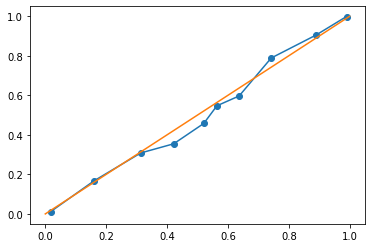

In [37]:
from sklearn.calibration import calibration_curve
calib_home_win = calibration_curve(test_values["home_win"], test_values["xhome_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_home_win[1], calib_home_win[0], marker="o")
plt.plot([0, 1], [0, 1])


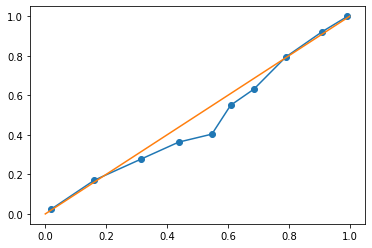

In [38]:
from sklearn.calibration import calibration_curve
calib_home_win = calibration_curve(test_values_old["home_win"], test_values_old["xhome_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_home_win[1], calib_home_win[0], marker="o")
plt.plot([0, 1], [0, 1])


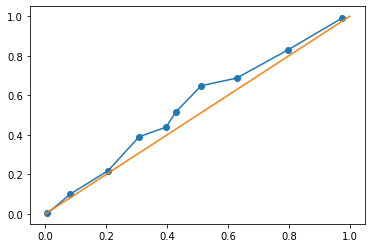

In [39]:
calib_away_win = calibration_curve(test_values["away_win"], test_values["xaway_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, 1], [0, 1])


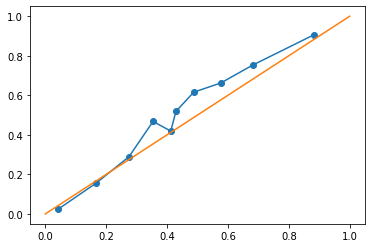

In [40]:
calib_df = test_values[test_values["quarter"]<=3]

calib_away_win = calibration_curve(calib_df["away_win"], calib_df["xaway_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, 1], [0, 1])


In [41]:
X_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), input_names]
y_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), output_name]
X_test_rf = full_df.loc[mask_test&(full_df.continuation==0), input_names].values
y_test_rf = full_df.loc[mask_test&(full_df.continuation==0), output_name].values




# rf = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=100).fit(X_train_rf, y_train_rf)
# pickle.dump(rf, open(os.path.join(root_dir, 'models/game_score_random_forest.p'), 'wb'))

# rf = pickle.load(open(os.path.join(root_dir, "models/game_score_random_forest.p"), 'rb'))
rf  = pickle.load(open(os.path.join(root_dir, "models/game_score_random_forest_100_10.p"), 'rb'))
os.system('say "done"')


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0

In [55]:
rf.score(X_test_rf, y_test_rf)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


0.0983107503133767

In [43]:
rf.score(X_test_rf, y_test_rf)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

0.09727564738073521

In [68]:
pd.concat([pd.DataFrame(rf.feature_importances_, index=rf.feature_names_in_), pd.DataFrame(rf_new.feature_importances_, index=rf.feature_names_in_)], axis=1)

,0,0
prior_home,0.039355,0.035990
prior_away,0.038068,0.034498
home_team_has_ball,0.026010,0.024419
home_start_score,0.087642,0.113888
away_start_score,0.087036,0.096561
quarter,0.369086,0.349338
overtime,0.014802,0.014145
play_start_time,0.140454,0.121585
yd_from_goal,0.048625,0.046009
from_scrimmage,0.003063,0.004951


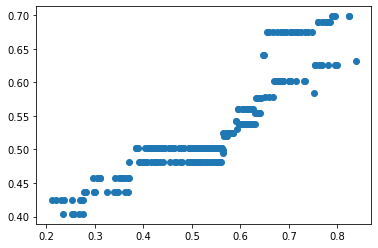

In [83]:
beginning_of_game = rf_df[rf_df["nevent"] == 1]
plt.scatter(beginning_of_game["prior_home"], beginning_of_game["xhome_win"])

In [74]:
beginning_of_game

,index,game_code,game_date_x,season,home_team_id_x,away_team_id_x,home_final_score,away_final_score,home_team_outcome,nevent,...,away_team_abbrev,prior_home,prior_away,game_date_y,home_win,draw,away_win,xhome_win,xdraw,xaway_win
0,700001,2337429,2021-09-09,2021,362,331,31,29,W,1,...,Dal,0.781111,0.215680,2021-09-09 20:20:00,1,0,0,0.621807,0.025002,0.353190
251,700252,2337430,2021-09-12,2021,323,354,6,32,L,1,...,Phi,0.630141,0.368075,2021-09-12 13:00:00,0,0,1,0.595853,0.026137,0.378011
482,700483,2337431,2021-09-12,2021,324,356,16,23,L,1,...,Pit,0.610895,0.387709,2021-09-12 13:00:00,0,0,1,0.592509,0.026275,0.381217
714,700715,2337432,2021-09-12,2021,327,347,27,24,W,1,...,Min,0.257030,0.741248,2021-09-12 13:00:00,1,0,0,0.558381,0.027587,0.414032
965,700966,2337433,2021-09-12,2021,334,359,33,41,L,1,...,SF,0.270741,0.728754,2021-09-12 13:00:00,0,0,1,0.533492,0.028446,0.438062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59323,759324,2337734,2021-11-21,2021,357,356,41,37,W,1,...,Pit,0.606054,0.391712,2021-11-21 17:20:00,1,0,0,0.618656,0.025146,0.356198
59561,759562,2337735,2021-11-22,2021,362,351,30,10,W,1,...,NYG,0.794771,0.203402,2021-11-22 20:15:00,1,0,0,0.624049,0.024899,0.351052
59767,759768,2411002,2021-12-20,2021,329,341,14,16,L,1,...,LV,0.494304,0.503935,2021-12-20 17:00:00,0,0,1,0.572340,0.027070,0.400589
59974,759975,2411003,2021-12-21,2021,354,363,27,17,W,1,...,Was,0.626113,0.372436,2021-12-21 19:00:00,1,0,0,0.622026,0.024992,0.352982


In [43]:
rf_output = get_model_outputs(rf, plot_input, plot_running_score)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.4s finished


In [44]:
from catboost import CatBoostClassifier
X_train_cb = full_df.loc[~mask_test&(full_df.continuation==0), input_names]
y_train_cb = full_df.loc[~mask_test&(full_df.continuation==0), "home_team_outcome"]
X_test_cb = full_df.loc[mask_test&(full_df.continuation==0), input_names]
y_test_cb = full_df.loc[mask_test&(full_df.continuation==0), "home_team_outcome"]

categoricals = [
    'home_team_has_ball',
    'overtime',
    'from_scrimmage',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    'down',
]
param_spaces={
    'random_strength': 39.38775510204081,
    'early_stopping_rounds': 5,
    'min_child_samples': 1,
    'max_depth': 12,
    'learning_rate': 0.05591836734693878,
    'l2_leaf_reg': 55.146938775510215}
cb = CatBoostClassifier(cat_features=categoricals, verbose=1, **param_spaces).fit(X_train_cb, y_train_cb)
pickle.dump(cb, open(os.path.join(root_dir, 'models/game_outcome_catboost.p'), 'wb'))

0:	learn: 1.0552832	total: 283ms	remaining: 4m 43s
1:	learn: 1.0176815	total: 596ms	remaining: 4m 57s
2:	learn: 0.9868490	total: 957ms	remaining: 5m 17s
3:	learn: 0.9529940	total: 2.88s	remaining: 11m 58s
4:	learn: 0.9223800	total: 3.94s	remaining: 13m 4s
5:	learn: 0.9016021	total: 4.28s	remaining: 11m 48s
6:	learn: 0.8766868	total: 5.01s	remaining: 11m 50s
7:	learn: 0.8587395	total: 5.13s	remaining: 10m 36s
8:	learn: 0.8364327	total: 5.41s	remaining: 9m 55s
9:	learn: 0.8166230	total: 5.79s	remaining: 9m 32s
10:	learn: 0.7963037	total: 6.64s	remaining: 9m 57s
11:	learn: 0.7843004	total: 6.77s	remaining: 9m 17s
12:	learn: 0.7654429	total: 7.27s	remaining: 9m 11s
13:	learn: 0.7487087	total: 7.88s	remaining: 9m 15s
14:	learn: 0.7345211	total: 8.71s	remaining: 9m 31s
15:	learn: 0.7215257	total: 9.64s	remaining: 9m 53s
16:	learn: 0.7094823	total: 10.4s	remaining: 10m 2s
17:	learn: 0.6975004	total: 11.2s	remaining: 10m 10s
18:	learn: 0.6879517	total: 11.6s	remaining: 9m 59s
19:	learn: 0.6772

In [45]:
full_df = full_df.reset_index()
full_df[["xaway_win", "xdraw", "xhome_win"]] = pd.DataFrame(cb.predict_proba(pd.DataFrame(full_df[input_names])))


In [46]:
full_df

,index,game_code,game_date_x,season,home_team_id_x,away_team_id_x,home_final_score,away_final_score,home_team_outcome,nevent,...,away_team_abbrev,prior_home,prior_away,game_date_y,home_win,draw,away_win,xaway_win,xdraw,xhome_win
0,0,887184,2009-09-10,2009,356,336,13,10,W,1,...,Ten,0.689458,0.303227,2009-09-10 20:30:00,1,0,0,0.314999,0.003100,0.681901
1,1,887184,2009-09-10,2009,356,336,13,10,W,2,...,Ten,0.689458,0.303227,2009-09-10 20:30:00,1,0,0,0.377799,0.004026,0.618175
2,2,887184,2009-09-10,2009,356,336,13,10,W,3,...,Ten,0.689458,0.303227,2009-09-10 20:30:00,1,0,0,0.267928,0.002797,0.729275
3,3,887184,2009-09-10,2009,356,336,13,10,W,4,...,Ten,0.689458,0.303227,2009-09-10 20:30:00,1,0,0,0.268591,0.002757,0.728652
4,4,887184,2009-09-10,2009,356,336,13,10,W,5,...,Ten,0.689458,0.303227,2009-09-10 20:30:00,1,0,0,0.291258,0.003103,0.705639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760368,760369,2411004,2021-12-21,2021,343,361,20,10,W,193,...,Sea,0.687837,0.310144,2021-12-21 16:00:00,1,0,0,0.017075,0.000188,0.982737
760369,760370,2411004,2021-12-21,2021,343,361,20,10,W,194,...,Sea,0.687837,0.310144,2021-12-21 16:00:00,1,0,0,0.017899,0.000204,0.981897
760370,760371,2411004,2021-12-21,2021,343,361,20,10,W,195,...,Sea,0.687837,0.310144,2021-12-21 16:00:00,1,0,0,0.014019,0.000123,0.985858
760371,760372,2411004,2021-12-21,2021,343,361,20,10,W,196,...,Sea,0.687837,0.310144,2021-12-21 16:00:00,1,0,0,0.014090,0.000123,0.985787


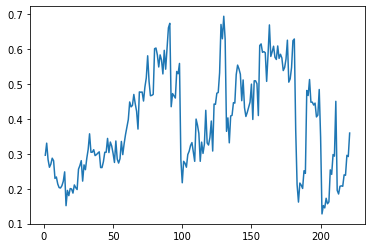

In [47]:
test_game_cb = full_df.loc[full_df.game_code==2337720]
plt.plot(test_game_cb["nevent"], test_game_cb["xhome_win"])

In [48]:
from copy import deepcopy
predict_tool = {
    'prior_home': .38,
    'prior_away': .62,
    'home_team_has_ball': None,
    'home_start_score': None,
    'away_start_score': None,
    'quarter': None,
    'overtime': None,
    'play_start_time': None,
    'yd_from_goal': None,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': [0, 1, 0],
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': [0, 0, 1],
    'down': 4,
    'ytg': None,
    'home_timeouts_remaining': None,
    'away_timeouts_remaining': None,
    
}
predict_input = pd.DataFrame(predict_tool, index=["go", "punt", "FGA"])
predict_tool_need = {
    'home_team_has_ball': 1,
    'home_start_score': 14,
    'away_start_score': 14,
    'quarter': 3,
    'overtime': 0,
    'play_start_time': 606,
    'yd_from_goal': 40,
    'ytg': 1,
    'home_timeouts_remaining': 3,
    'away_timeouts_remaining': 3,
}
predict_input[[
    'home_team_has_ball',
    'home_start_score',
    'away_start_score',
    'quarter',
    'overtime',
    'play_start_time',
    'yd_from_goal',
    'ytg',
    'home_timeouts_remaining',
    'away_timeouts_remaining']] = list(predict_tool_need.values())
cb.predict_proba(predict_input)

array([[5.74036883e-01, 4.88136859e-04, 4.25474981e-01],
       [5.99195569e-01, 5.19663222e-04, 4.00284767e-01],
       [5.73168151e-01, 5.45923177e-04, 4.26285926e-01]])

In [49]:
predict_input

,prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
go,0.38,0.62,1,14,14,3,0,606,40,1,0,0,0,0,0,4,1,3,3
punt,0.38,0.62,1,14,14,3,0,606,40,1,0,1,0,0,0,4,1,3,3
FGA,0.38,0.62,1,14,14,3,0,606,40,1,0,0,0,0,1,4,1,3,3


In [50]:

predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_field_goal = deepcopy(predict_input_go_for_it)
predict_input_field_goal["field_goal_attempt"] = 1

print(np.around(cb.predict_proba(predict_input), 3))
print(np.around(cb.predict_proba(predict_input_go_for_it), 3))
print(np.around(cb.predict_proba(predict_input_field_goal), 3))


ValueError: could not broadcast input array from shape (3,) into shape (1,)

In [ ]:
calib_df = full_df

calib_away_win = calibration_curve(calib_df["draw"], calib_df["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, .04], [0, .04])


In [ ]:
full_df[mask_test][-1:].values


In [80]:
rf_df = pd.concat([test_df, pd.DataFrame(rf_output["ft_outcome"], columns=["xhome_win", "xdraw", "xaway_win"]), pd.DataFrame(rf_output["home_score"])], axis=1)

In [ ]:
pd.DataFrame(rf_output["home_score"]).drop_duplicates()

In [ ]:
test_game_rf = rf_df[rf_df["game_code"]==2337720]
plt.plot(test_game_rf["nevent"], test_game_rf["xhome_win"])


In [ ]:
plt.plot(test_game["nevent"], test_game["xhome_win"])

In [ ]:
calib_df = test_values[test_values["quarter"]==3]

calib_draw = calibration_curve(calib_df["draw"], calib_df["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_draw = calibration_curve(test_values["draw"], test_values["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_draw = calibration_curve(test_values_old["draw"], test_values_old["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
test_game = test_values[test_values["game_code"]==2337720]
test_game["home_win_no_ties"] = test_game["xhome_win"] / (test_game["xhome_win"] + test_game["xaway_win"])
test_game["away_win_no_ties"] = test_game["xaway_win"] / (test_game["xhome_win"] + test_game["xaway_win"])

NameError: name 'test_game' is not defined

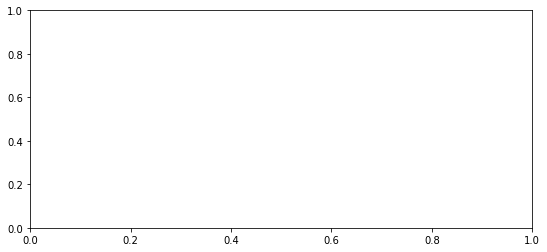

In [44]:
h_f, h_ax = plt.subplots(1, figsize=(9, 4))
plot_time = test_game[['quarter', 'play_start_time']]
plot_time = ((900 - plot_time.play_start_time) + \
                (plot_time.quarter - 1 ) * 900).values
plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
plot_y1 = np.vstack((test_game["home_win_no_ties"], test_game["home_win_no_ties"])).flatten(order='F')[:-1]
plot_y2 = np.vstack((test_game["away_win_no_ties"], test_game["away_win_no_ties"])).flatten(order='F')[:-1]
h_ax.stackplot(plot_x, plot_y1, plot_y2,
                labels=['Chiefs','Bills'],
                colors=['#E31837', '#00338D'],
                zorder=0)
h_ax.legend(loc='upper left')
if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
    x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
    x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
else:
    x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
    x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
    
h_ax.set_xticks(x_tick_pos)
h_ax.set_xticklabels(x_tick_str)
h_ax.set_xlabel('Match time')
h_ax.set_xlim(0, plot_x.max())
h_ax.set_ylim(0, 1)
h_ax.set_yticks(np.arange(0, 1.01, 0.25))
h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
h_ax.set_ylabel('Probability')
h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))


In [ ]:
plt.plot(plot_time, test_game["home_win_no_ties"], '-k')

In [ ]:
from copy import deepcopy
plot_game_code = 2337720
mask_fourth_down_bot = (full_df.game_code.isin(test_game_codes))&(full_df.down==4)&(full_df.from_scrimmage==1)
plot_input_fourth_down_bot = full_df.loc[mask_fourth_down_bot,input_names]
plot_input_fourth_down_bot_go = deepcopy(plot_input_fourth_down_bot)
plot_input_fourth_down_bot_punt = deepcopy(plot_input_fourth_down_bot)
plot_input_fourth_down_bot_go["punt"] = 0
plot_input_fourth_down_bot_punt["punt"] = 1
plot_running_score_fourth_down_bot = full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
plot_output_fourth_down_bot = get_model_outputs(clf, plot_input_fourth_down_bot, plot_running_score_fourth_down_bot)
plot_output_fourth_down_bot_go = get_model_outputs(clf, plot_input_fourth_down_bot_go, plot_running_score_fourth_down_bot)
plot_output_fourth_down_bot_punt = get_model_outputs(clf, plot_input_fourth_down_bot_punt, plot_running_score_fourth_down_bot)
test_df_fourth_down_bot = full_df.loc[mask_fourth_down_bot, full_df.columns].reset_index()
test_values_fourth_down_bot = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
test_values_fourth_down_bot_go = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot_go['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
test_values_fourth_down_bot_punt = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot_punt['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)


In [ ]:
test_values_fourth_down_bot["xhome_win_go"] = test_values_fourth_down_bot_go["xhome_win"]
test_values_fourth_down_bot["xhome_win_punt"] = test_values_fourth_down_bot_punt["xhome_win"]
test_values_fourth_down_bot["xgo_advantage"] = test_values_fourth_down_bot['xhome_win_go'] - test_values_fourth_down_bot['xhome_win_punt']

In [ ]:
test_df_fourth_down_bot

In [ ]:
min(test_df_fourth_down_bot[test_df_fourth_down_bot["punt"]==1]["yd_from_goal"])

In [ ]:
max(test_df_fourth_down_bot[test_df_fourth_down_bot["field_goal_attempt"]==1]["yd_from_goal"])

In [ ]:
np.array([24, 17])

In [ ]:
predict_tool = {
    'prior_home': .6,
    'prior_away': .3995,
    'home_team_has_ball': 0,
    'home_start_score': 24,
    'away_start_score': 20,
    'quarter': 4,
    'overtime': 0,
    'play_start_time': 200,
    'yd_from_goal': 5,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': 1,
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': 0,
    'down': 4,
    'ytg': 1,
}
predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_go_for_it["punt"] = 0
predict_running_score = predict_input[["home_start_score", "away_start_score"]].values
# full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
print(get_model_outputs(clf, predict_input, predict_running_score)["ft_outcome"])
print(get_model_outputs(clf, predict_input_go_for_it, predict_running_score)["ft_outcome"])


In [ ]:
predict_tool = {
    'prior_home': .6,
    'prior_away': .4,
    'home_team_has_ball': 0,
    'home_start_score': 24,
    'away_start_score': 20,
    'quarter': 4,
    'overtime': 0,
    'play_start_time': 200,
    'yd_from_goal': 5,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': 1,
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': 0,
    'down': 4,
    'ytg': 1,
}
predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_go_for_it["punt"] = 0
predict_running_score = predict_input[["home_start_score", "away_start_score"]].values
# full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
print(get_model_outputs(clf, predict_input, predict_running_score)["ft_outcome"])
print(get_model_outputs(clf, predict_input_go_for_it, predict_running_score)["ft_outcome"])


In [ ]:


full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
get_model_outputs(clf, predict_input, np.array([24, 17]).values())

In [ ]:
full_df["ytg_bucket"] = round((full_df["yd_from_goal"]-5)/10) * 10
fourth_downs = full_df.loc[mask_fourth_down_bot]

fourth_downs[input_names+["ytg_bucket"]].groupby("ytg_bucket").mean()

In [ ]:
fourth_downs["yd_from_goal"].drop_duplicates().sort_values()

In [ ]:
extra_point = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1), input_names].values
extra_point_all = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1)].values
extra_point_running_score = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1), ["home_start_score", "away_start_score"]].values
extra_point_outputs = get_model_outputs(clf, extra_point, extra_point_running_score)
extra_point_df = pd.concat([pd.DataFrame(extra_point_all, columns=full_df.columns), pd.DataFrame(extra_point_outputs["home_score"])], axis=1)

In [ ]:
clf.intercepts_[2]

In [ ]:
extra_point_df.to_csv("test.csv")

In [ ]:
extra_point

In [ ]:
full_df[["event_id", "event_name"]].drop_duplicates().sort_values("event_id")